# **Object Detection Model to Enhance Security Measures in the Construction Industry.**





**Objective:** Ensure workers and individuals in the construction area are properly equipped by detecting if they are wearing helmets and vests, as required by law and regulations.

**Aproach:** Utilize the pretrained YOLOV10 Computer Vision model and retrain it using transfer learning with a labeled dataset from Roboflow Universe.

## GPU Accesibility


Running the nvidia-smi command to display information about the NVIDIA GPU and its usage.

In [ ]:
!nvidia-smi

Thu Jun 27 09:01:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Getting the current working directory .

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv10

Installing the YOLOv10 library from the specified GitHub repository using pip.

In [ ]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 50.8 MB/s eta 0:00:00



Installing the supervision and roboflow libraries using pip.

In [ ]:
!pip install -q supervision roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.6 MB/s eta 0:00:00


## Download pre-trained weights

Creating a directory named weights in the current working directory, downloading various YOLOv10 model weights into this directory, and then listing the files in the weights directory with detailed information.








In [ ]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 408M
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


## Download dataset from Roboflow Universe

We selected the following labeled dataset:
https://universe.roboflow.com/safetyfinal/safety-final-wuat2/dataset/2


Creating a datasets directory, changing to that directory, installing the Roboflow library, and using Roboflow API to download a YOLOv8 dataset from a specific project and version.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="gCC3d3wAVyjdUhLLeDhG")
project = rf.workspace("safetyfinal").project("safety-final-wuat2")
version = project.version(2)
dataset = version.download("yolov8")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to safety-final-2 in yolov8:: 100%|██████████| 5172/5172 [00:00<00:00, 5680.38it/s]



Removing the last four lines from the data.yaml file in the downloaded dataset's location, and appending new paths for the train, validation, and test image directories.

In [ ]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "train: ../train/images\nval: ../valid/images\ntest: ../test/images" >> {dataset.location}/data.yaml


Displaying the contents of the modified data.yaml file to verify the changes.

In [ ]:
!cat {dataset.location}/data.yaml

names:
- helmet
- vest
nc: 2
roboflow:
  license: CC BY 4.0
  project: safety-final-wuat2
  url: https://universe.roboflow.com/safetyfinal/safety-final-wuat2/dataset/2
  version: 2
train: ../train/images
val: ../valid/images
test: ../test/images


## Custom Training

Changing the working directory to the home directory and starting the YOLO detection training with the specified parameters: task set to detection, mode set to train, 25 epochs, batch size of 32, enabling plot generation, using the yolov10n.pt model weights, and the data.yaml file for data configuration.

In [ ]:
%cd {HOME}

!yolo task=detect mode=train epochs=25 batch=32 plots=True \
model={HOME}/weights/yolov10n.pt \
data={dataset.location}/data.yaml

/content
New https://pypi.org/project/ultralytics/8.2.45 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10n.pt, data=/content/datasets/safety-final-2/data.yaml, epochs=25, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=

Listing the contents of the directory {HOME}/runs/detect/train/ to display the results of the YOLO training process.

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    R_curve.png		val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv		val_batch0_pred.jpg
confusion_matrix.png				    results.png		val_batch1_labels.jpg
events.out.tfevents.1719479041.7b8416d0a866.1225.0  train_batch0.jpg	val_batch1_pred.jpg
F1_curve.png					    train_batch1.jpg	val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch2.jpg	val_batch2_pred.jpg
labels.jpg					    train_batch855.jpg	weights
P_curve.png					    train_batch856.jpg
PR_curve.png					    train_batch857.jpg


In [ ]:
pip install pillow


Changing the working directory to the home directory and displaying the confusion matrix image from the YOLO training results.

/content


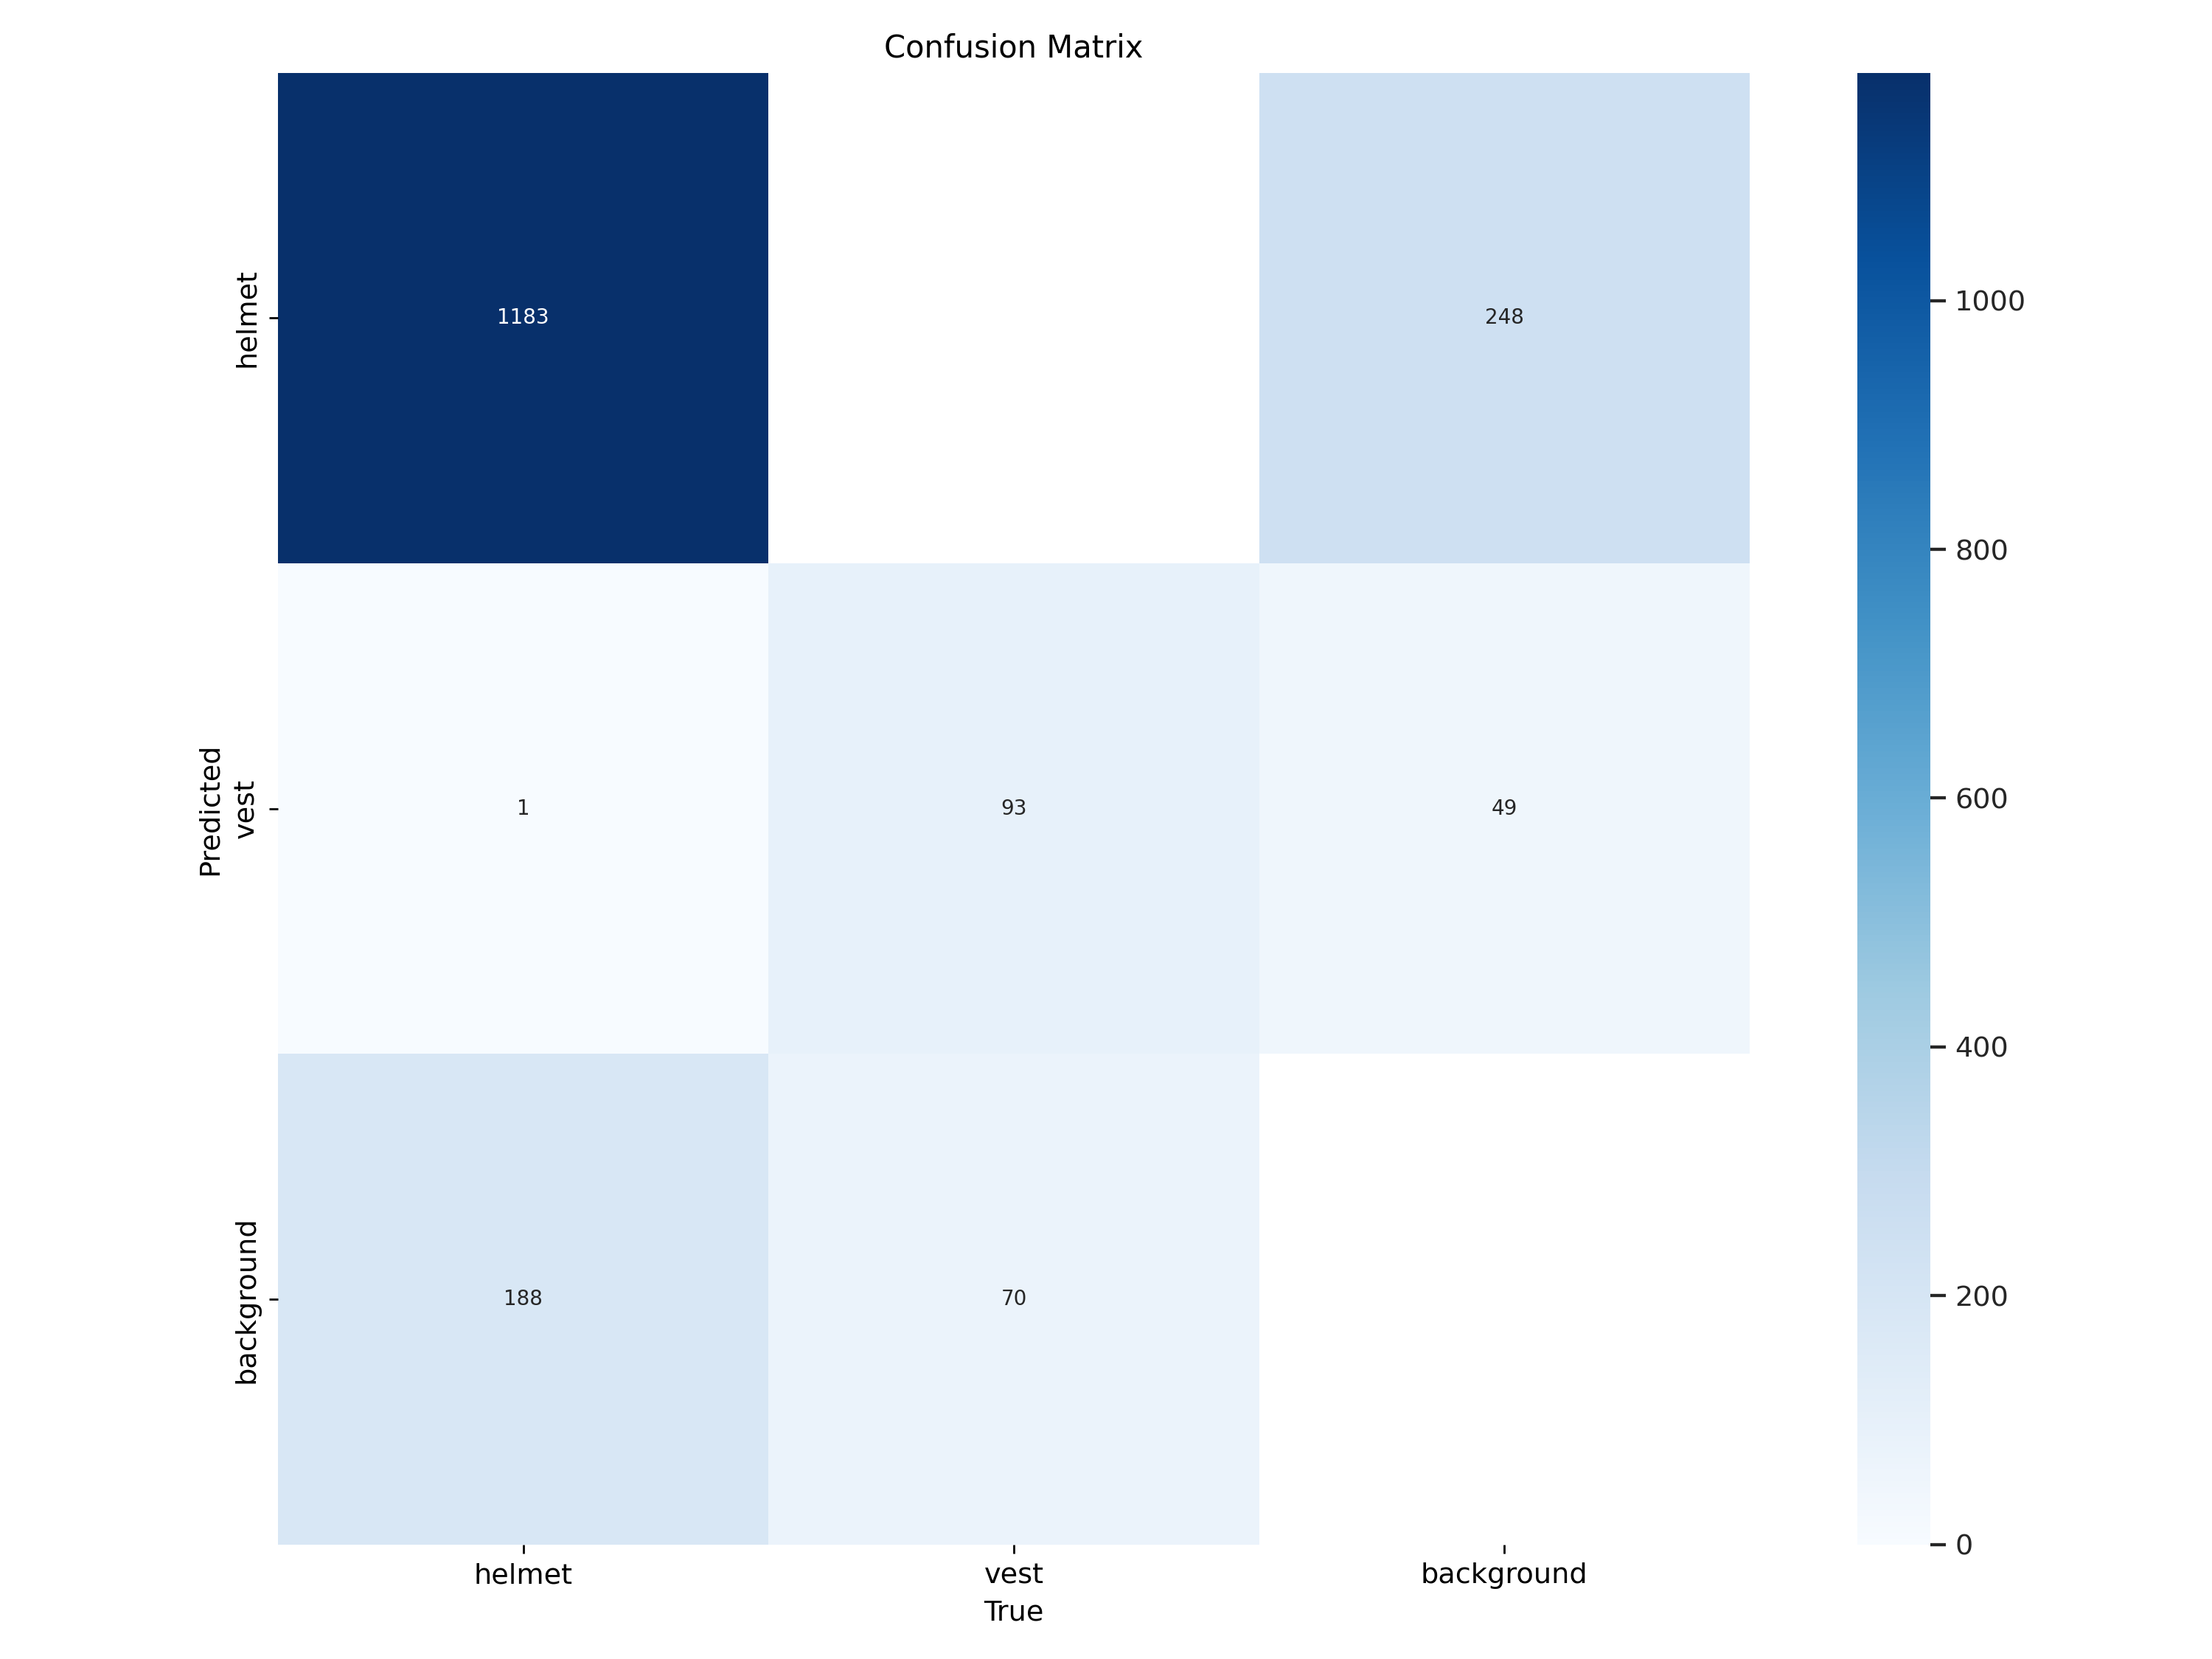

In [ ]:
from IPython.display import Image

%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)


Changing the working directory to the home directory and displaying the training results image from the YOLO training process.

/content


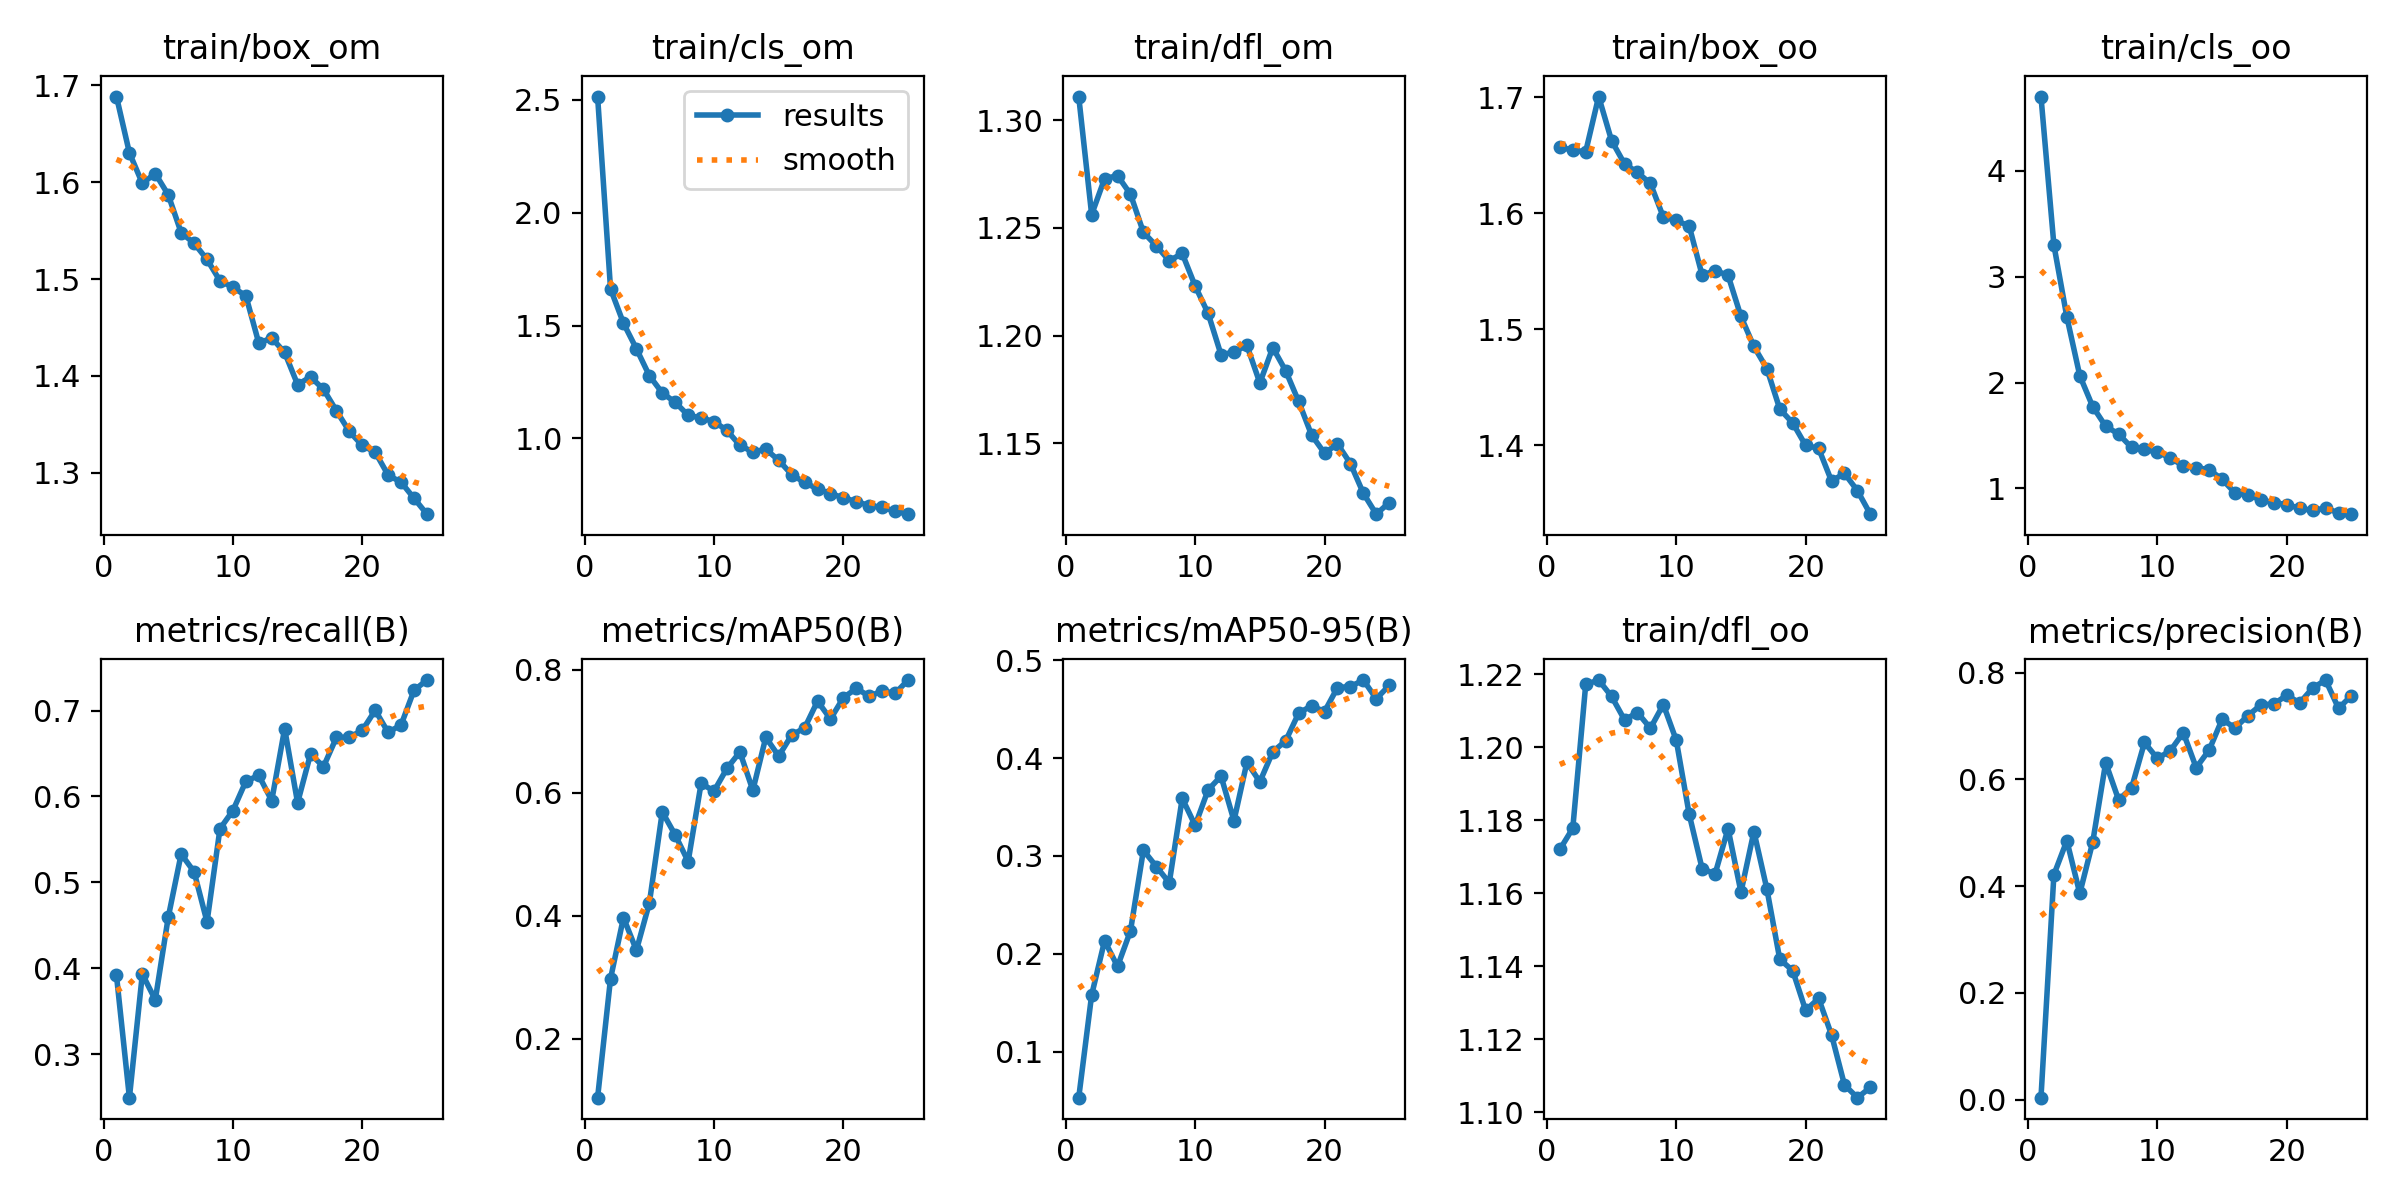

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

### Training Metrics:

- **train/box_om**: The bounding box loss decreased from approximately 1.7 to 1.32 over 25 epochs, indicating improved bounding box predictions.
- **train/cls_om**: The classification loss decreased from 2.5 to 1.2, showing better classification performance.
- **train/dfl_om**: The focal loss decreased from 1.3 to 1.1, suggesting the model is focusing better on hard examples.
- **train/box_oo**: The bounding box loss decreased from 1.7 to 1.2, similar to train/box_om, showing consistent improvement.
- **train/cls_oo**: The classification loss decreased sharply from 4.2 to 1.0, indicating significant improvement.

### Evaluation Metrics:

- **metrics/recall(B)**: Recall improved from 0.3 to 0.7, indicating the model is identifying a higher proportion of actual positives.
- **metrics/mAP50(B)**: mAP at 50% IoU increased from 0.2 to 0.75, showing substantial improvement in detection accuracy.
- **metrics/mAP50-95(B)**: mAP averaged over 50-95% IoU increased from 0.1 to 0.5, indicating better performance across varying IoU thresholds.
- **metrics/precision(B)**: Precision improved from 0.2 to 0.75, meaning the model is reducing false positives and making more accurate predictions.

### Summary:

The quantitative data extracted from the plots show a clear trend of improvement across all metrics. Training losses consistently decreased, indicating effective learning. Evaluation metrics, including recall, precision, and mAP, all showed significant improvements, suggesting that the model's performance in detecting and classifying objects became markedly better over the 25 epochs.


## Inference with Custom Model

Importing the necessary libraries and loading the trained YOLOv10 model from the best weights. Creating a detection dataset from the validation images and labels using the supervision library. Initializing bounding box and label annotators for visualizing the detections.

In [ ]:
import supervision as sv
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/runs/detect/train/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

Validating the model selecting images from our validation set and visualize the results.

Image 1


0: 640x640 6 helmets, 29.2ms
Speed: 8.8ms preprocess, 29.2ms inference, 310.8ms postprocess per image at shape (1, 3, 640, 640)


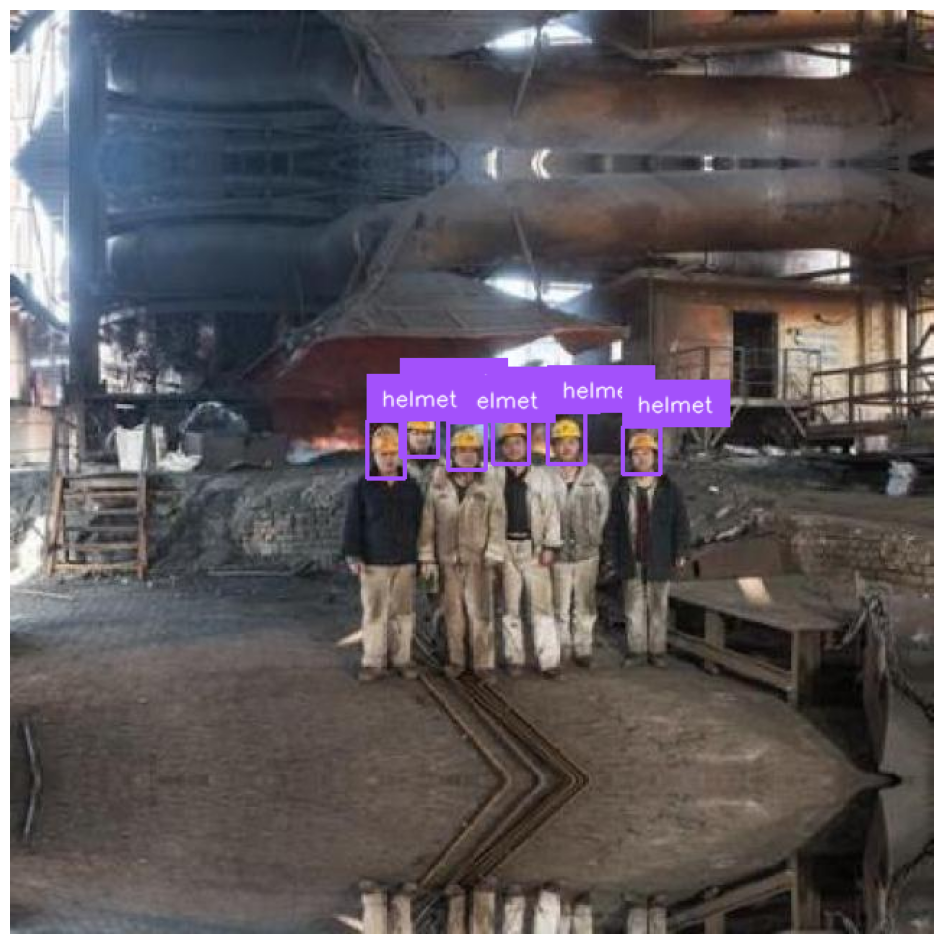

In [ ]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

Image 2


0: 640x640 3 helmets, 19.4ms
Speed: 2.0ms preprocess, 19.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


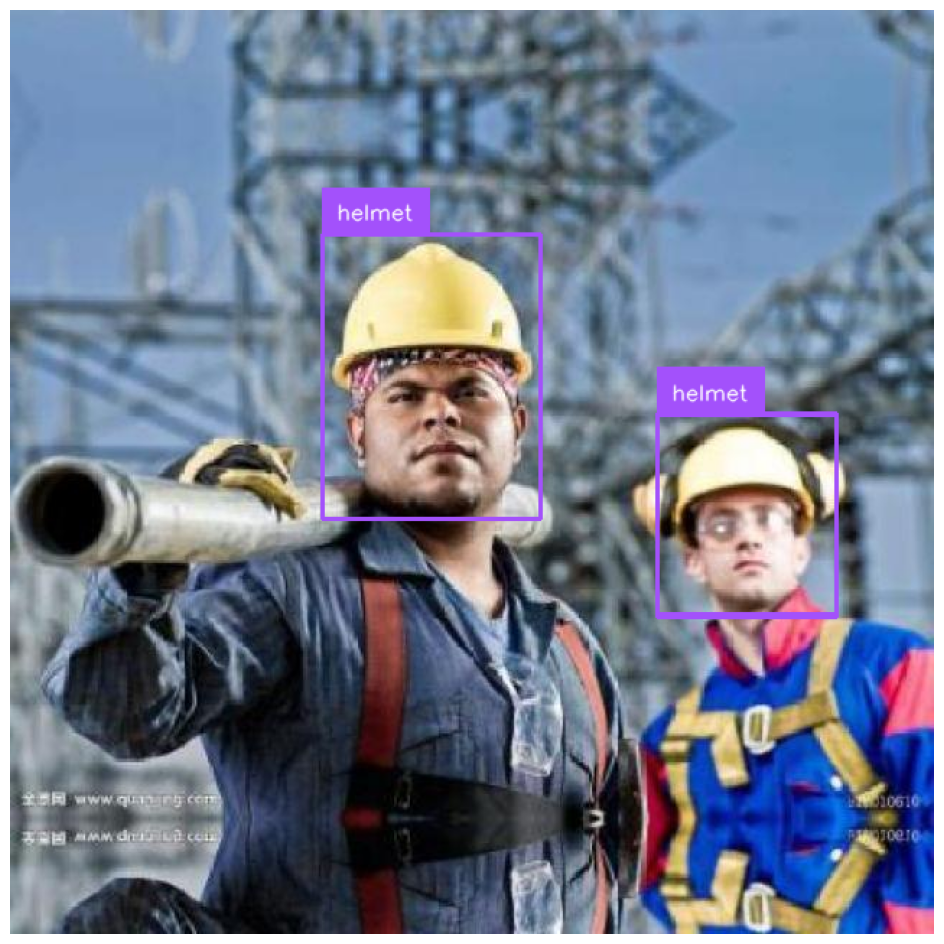

In [ ]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

Image 3


0: 640x640 10 helmets, 3 vests, 14.0ms
Speed: 1.9ms preprocess, 14.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


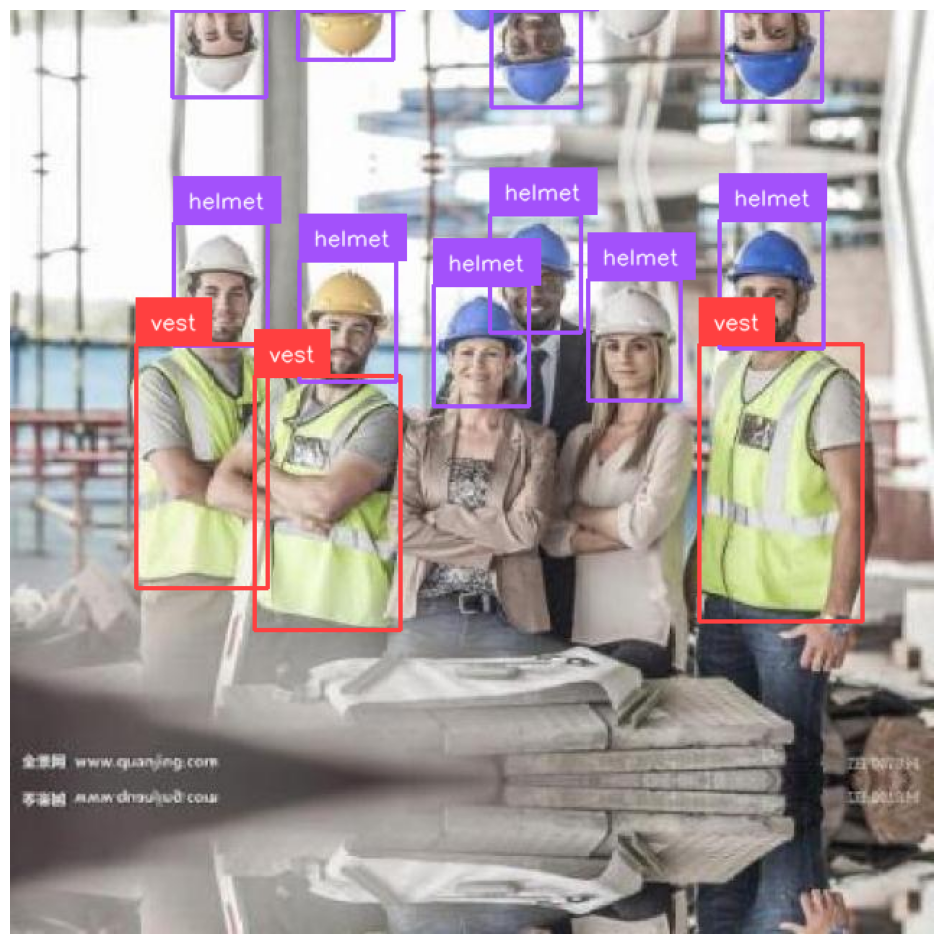

In [ ]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

Image 4


0: 640x640 3 helmets, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


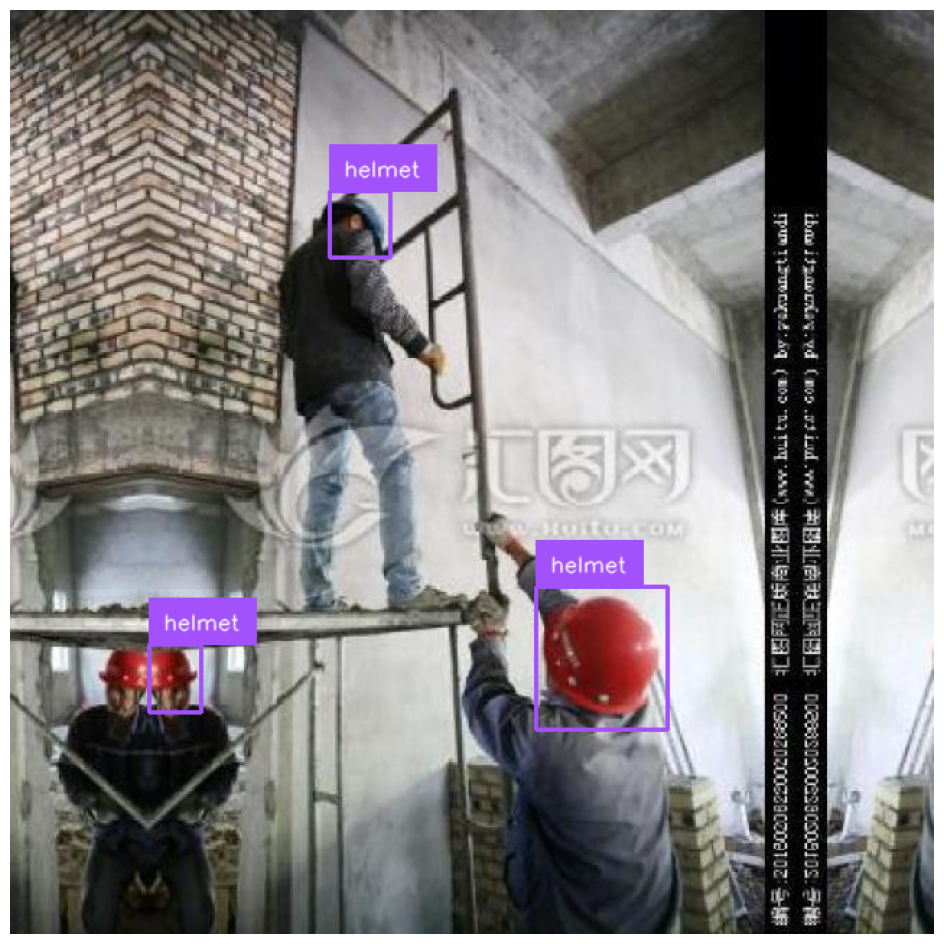

In [ ]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

Image 5


0: 640x640 1 helmet, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


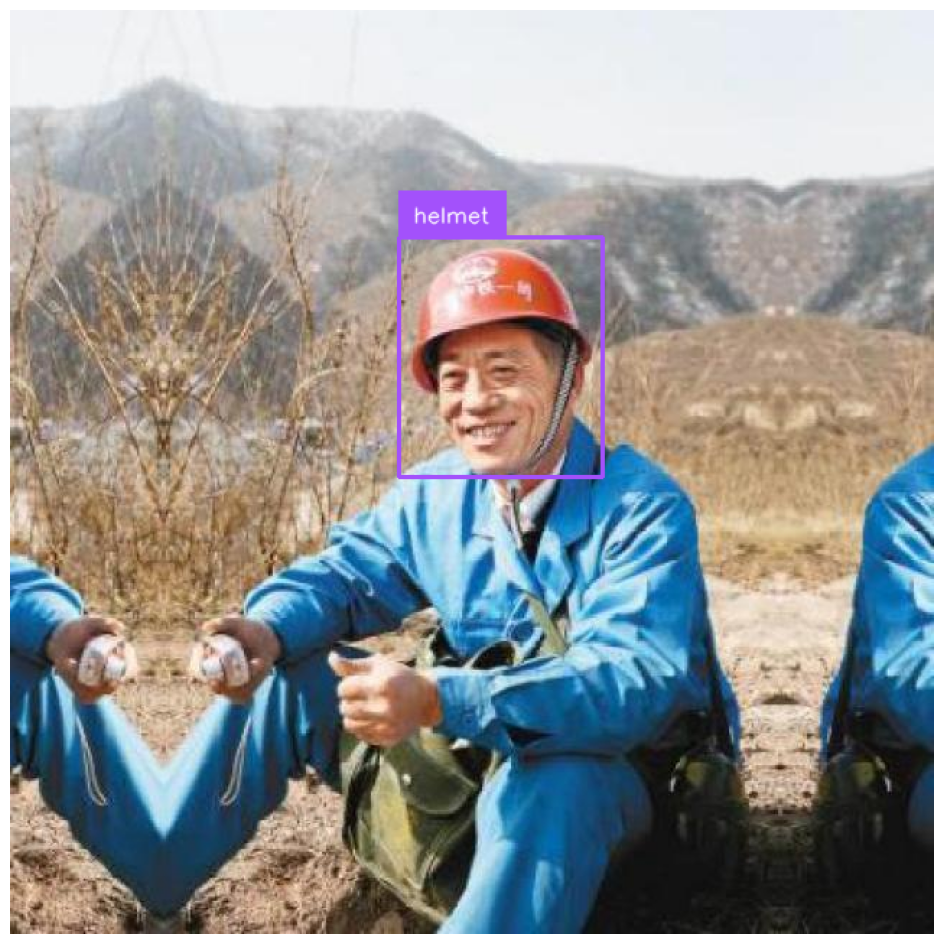

In [ ]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

Based on the collected samples, we can confirm that the model is functioning correctly. However, if deployed in a production environment, further validation and testing will be necessary to enhance and optimize its performance.